# Part One: Fitting Models

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures,label_binarize,LabelBinarizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from plotnine import *
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error,accuracy_score,confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,classification_report,roc_curve,auc,cohen_kappa_score
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier,plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Read the data
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha.head(1)

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1


In [ ]:
ha= ha.dropna()
ha.head(1)

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1


In [ ]:
# make sure you map the dummy variables to what they are actually called so whenn you use onehot encoder we can know which categorical variables are affected
cp = {
    0: 'Typical Angina',
    1: 'Atypical Angina',
    2: 'Non-Anginal Pain',
    3: 'Asymptomatic'
}

# Replace the values in the 'cp' column
ha['cp'] = ha['cp'].map(cp)
ha.head(1)

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,Asymptomatic,145,233,0,150,1


In [ ]:
restecg = {
    0: 'Normal',
    1: 'Abnormal',
    2: 'Prob/Definite'
}

# Replace the values in the 'restecg' column
ha['restecg'] = ha['restecg'].map(restecg)
ha.head(1)

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,Asymptomatic,145,233,Normal,150,1


In [ ]:
risk = {
    0: 'Not at risk',
    1: 'At risk'
}

# Replace the values in the 'output' column
ha['output'] = ha['output'].map(risk)
ha.head(5)

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,Asymptomatic,145,233,Normal,150,At risk
1,37,1,Non-Anginal Pain,130,250,Abnormal,187,At risk
2,56,1,Atypical Angina,120,236,Abnormal,178,At risk
3,57,0,Typical Angina,120,354,Abnormal,163,At risk
4,57,1,Typical Angina,140,192,Abnormal,148,At risk


In [ ]:
X = ha.drop(['output'], axis=1)
y = ha['output']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Q1: KNN


After experimenting with various values for k in our K-Nearest Neighbors model, we determined that a k value of 50 yields a roc_auc score of 84%. This finding suggests that when considering the 50 nearest neighbors for making predictions, our model achieves the best balance between overfitting and underfitting, leading to the most accurate results. We now move to fittign our model with the 50 nearest neighbors

In [ ]:
# Create the pipeline
my_pipeline_knn = Pipeline([
    ("standerdize_dummify", ct),
    ("knn", KNeighborsClassifier(n_neighbors=50))
])

# Fit the pipeline on the training data
my_pipeline_knn.fit(X_train, y_train)


Pipeline(steps=[('standerdize_dummify',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7c02b90e9690>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7c02b90ebac0>)])),
                ('knn', KNeighborsClassifier(n_neighbors=50))])

1. Create the confusion matrix

In [ ]:
# Confusion matrix
uni_classes = y.unique() #getting the unique classes in the Y variale
y_pred = my_pipeline_knn.predict(X_test)
conf_matrix_test = confusion_matrix(y_test, y_pred) # making the matrix

class_names = uni_classes.tolist() # Putting the classes to a list

conf_matrix_df = pd.DataFrame(conf_matrix_test, index=class_names, columns=class_names) # Display the confusion matrix with class labels
conf_matrix_df

,At risk,Not at risk
At risk,15,14
Not at risk,8,18


In [ ]:
# Classification Report
recall_scores1 = classification_report(y_test, y_pred, output_dict=True) # Classification Report
recall_scores1 = pd.DataFrame(recall_scores1).transpose()
recall_scores1

,precision,recall,f1-score,support
At risk,0.652174,0.517241,0.576923,29.0
Not at risk,0.562500,0.692308,0.620690,26.0
accuracy,0.600000,0.600000,0.600000,0.6
macro avg,0.607337,0.604775,0.598806,55.0
weighted avg,0.609783,0.600000,0.597613,55.0


In [ ]:
# Find the Roc and Auc using cross validation
cv_scores_knn = cross_val_score(my_pipeline_knn, X, y, cv=5, scoring='roc_auc_ovr')
mean_cv_score_knn = np.mean(cv_scores_knn)
mean_cv_score_knn

0.8433478337754201

## Q2: Logistic Regression

After thorough experimentation with our logistic regression model, we determined that setting lambda (regularization strength C) to 1 and alpha (balance between L1 and L2 regularization, l1_ratio) to 0.9 yields the optimal performance with a ROC AUC score of 87%.

In [ ]:
my_pipeline_log_regress = Pipeline([
    ("standardize_dummify", ct),
    ("logreg", LogisticRegression(penalty='elasticnet', C=1, l1_ratio=0.9, solver='saga'))
])
# fit on whole model on the X train and y train after you create pipeline with the specified hyperparameters
my_pipeline_log_regress.fit(X_train, y_train)

Pipeline(steps=[('standardize_dummify',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7c02c50b0730>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7c02c50b2ec0>)])),
                ('logreg',
                 LogisticRegression(C=1, l1_ratio=0.9, penalty='elasticnet',
                                    solver='saga'))])

In [ ]:
logreg_model = my_pipeline_log_regress.named_steps['logreg']
coefficients = logreg_model.coef_[0]
feature_names = my_pipeline_log_regress.named_steps['standardize_dummify'].get_feature_names_out()
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df

,Feature,Coefficient
0,dummify__cp_Asymptomatic,0.000000
1,dummify__cp_Atypical Angina,-0.581725
2,dummify__cp_Non-Anginal Pain,0.000000
3,dummify__cp_Typical Angina,1.909340
4,dummify__restecg_Abnormal,0.000000
5,dummify__restecg_Normal,0.000000
6,dummify__restecg_Prob/Definite,0.000000
7,standardize__age,0.280535
8,standardize__sex,1.149006
9,standardize__trtbps,0.145450


1. Create the confusion matrix

In [ ]:
# Confusion matrix
y_pred = my_pipeline_log_regress.predict(X_test)
conf_matrix_test1 = confusion_matrix(y_test, y_pred) # making the matrix
conf_matrix_df_log = pd.DataFrame(conf_matrix_test1, index=class_names, columns=class_names) # Display the confusion matrix with class labels
conf_matrix_df_log

,At risk,Not at risk
At risk,17,12
Not at risk,8,18


In [ ]:
# Classification Report
recall_scores = classification_report(y_test, y_pred, output_dict=True) # Classification Report
recall_scores = pd.DataFrame(recall_scores).transpose()
recall_scores

,precision,recall,f1-score,support
At risk,0.680000,0.586207,0.629630,29.000000
Not at risk,0.600000,0.692308,0.642857,26.000000
accuracy,0.636364,0.636364,0.636364,0.636364
macro avg,0.640000,0.639257,0.636243,55.000000
weighted avg,0.642182,0.636364,0.635883,55.000000


In [ ]:
# Find the Roc and Auc using cross validation
cv_scores_log = cross_val_score(my_pipeline_log_regress, X, y, cv=5, scoring='roc_auc_ovr')
mean_cv_score_log = np.mean(cv_scores_log)
mean_cv_score_log

0.8683939876215738

## Q3: Decision Tree

Following comprehensive testing with our Decision Tree model, we established that a maximum depth of 3 results in the optimal performance, achieving a ROC AUC score of 0.80.

In [ ]:
# Update the pipeline with the best found max_depth
my_pipeline_dt = Pipeline([
    ("standardize_dummify", ct),
    ("dt", DecisionTreeClassifier(max_depth=3))
])

# Fit on the training data
my_pipeline_dt.fit(X_train, y_train)

Pipeline(steps=[('standardize_dummify',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7c02c50b0730>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7c02c50b2ec0>)])),
                ('dt', DecisionTreeClassifier(max_depth=3))])

In [ ]:
dt_model = my_pipeline_dt.named_steps['dt']
feature_importances = dt_model.feature_importances_
feature_names = my_pipeline_dt.named_steps['standardize_dummify'].get_feature_names_out()
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importances_df

,Feature,Importance
0,dummify__cp_Asymptomatic,0.000000
1,dummify__cp_Atypical Angina,0.000000
2,dummify__cp_Non-Anginal Pain,0.000000
3,dummify__cp_Typical Angina,0.568116
4,dummify__restecg_Abnormal,0.000000
5,dummify__restecg_Normal,0.000000
6,dummify__restecg_Prob/Definite,0.000000
7,standardize__age,0.060602
8,standardize__sex,0.100022
9,standardize__trtbps,0.060913


1. Create the confusion matrix

In [ ]:
# Confusion matrix and classification report
y_pred_dt = my_pipeline_dt.predict(X_test)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
conf_matrix_df_dt = pd.DataFrame(conf_matrix_dt, index=class_names, columns=class_names)
conf_matrix_df_dt

,At risk,Not at risk
At risk,18,11
Not at risk,9,17


In [ ]:
recall_scores_dt = classification_report(y_test, y_pred_dt, output_dict=True)
recall_scores_df_dt = pd.DataFrame(recall_scores_dt).transpose()
recall_scores_df_dt

,precision,recall,f1-score,support
At risk,0.666667,0.620690,0.642857,29.000000
Not at risk,0.607143,0.653846,0.629630,26.000000
accuracy,0.636364,0.636364,0.636364,0.636364
macro avg,0.636905,0.637268,0.636243,55.000000
weighted avg,0.638528,0.636364,0.636604,55.000000


In [ ]:
# Find the Roc and Auc using cross validation
cv_scores_dt = cross_val_score(my_pipeline_dt, X, y, cv=5, scoring='roc_auc_ovr')
mean_cv_score_dt = np.mean(cv_scores_dt)
mean_cv_score_dt

0.7732371352785147

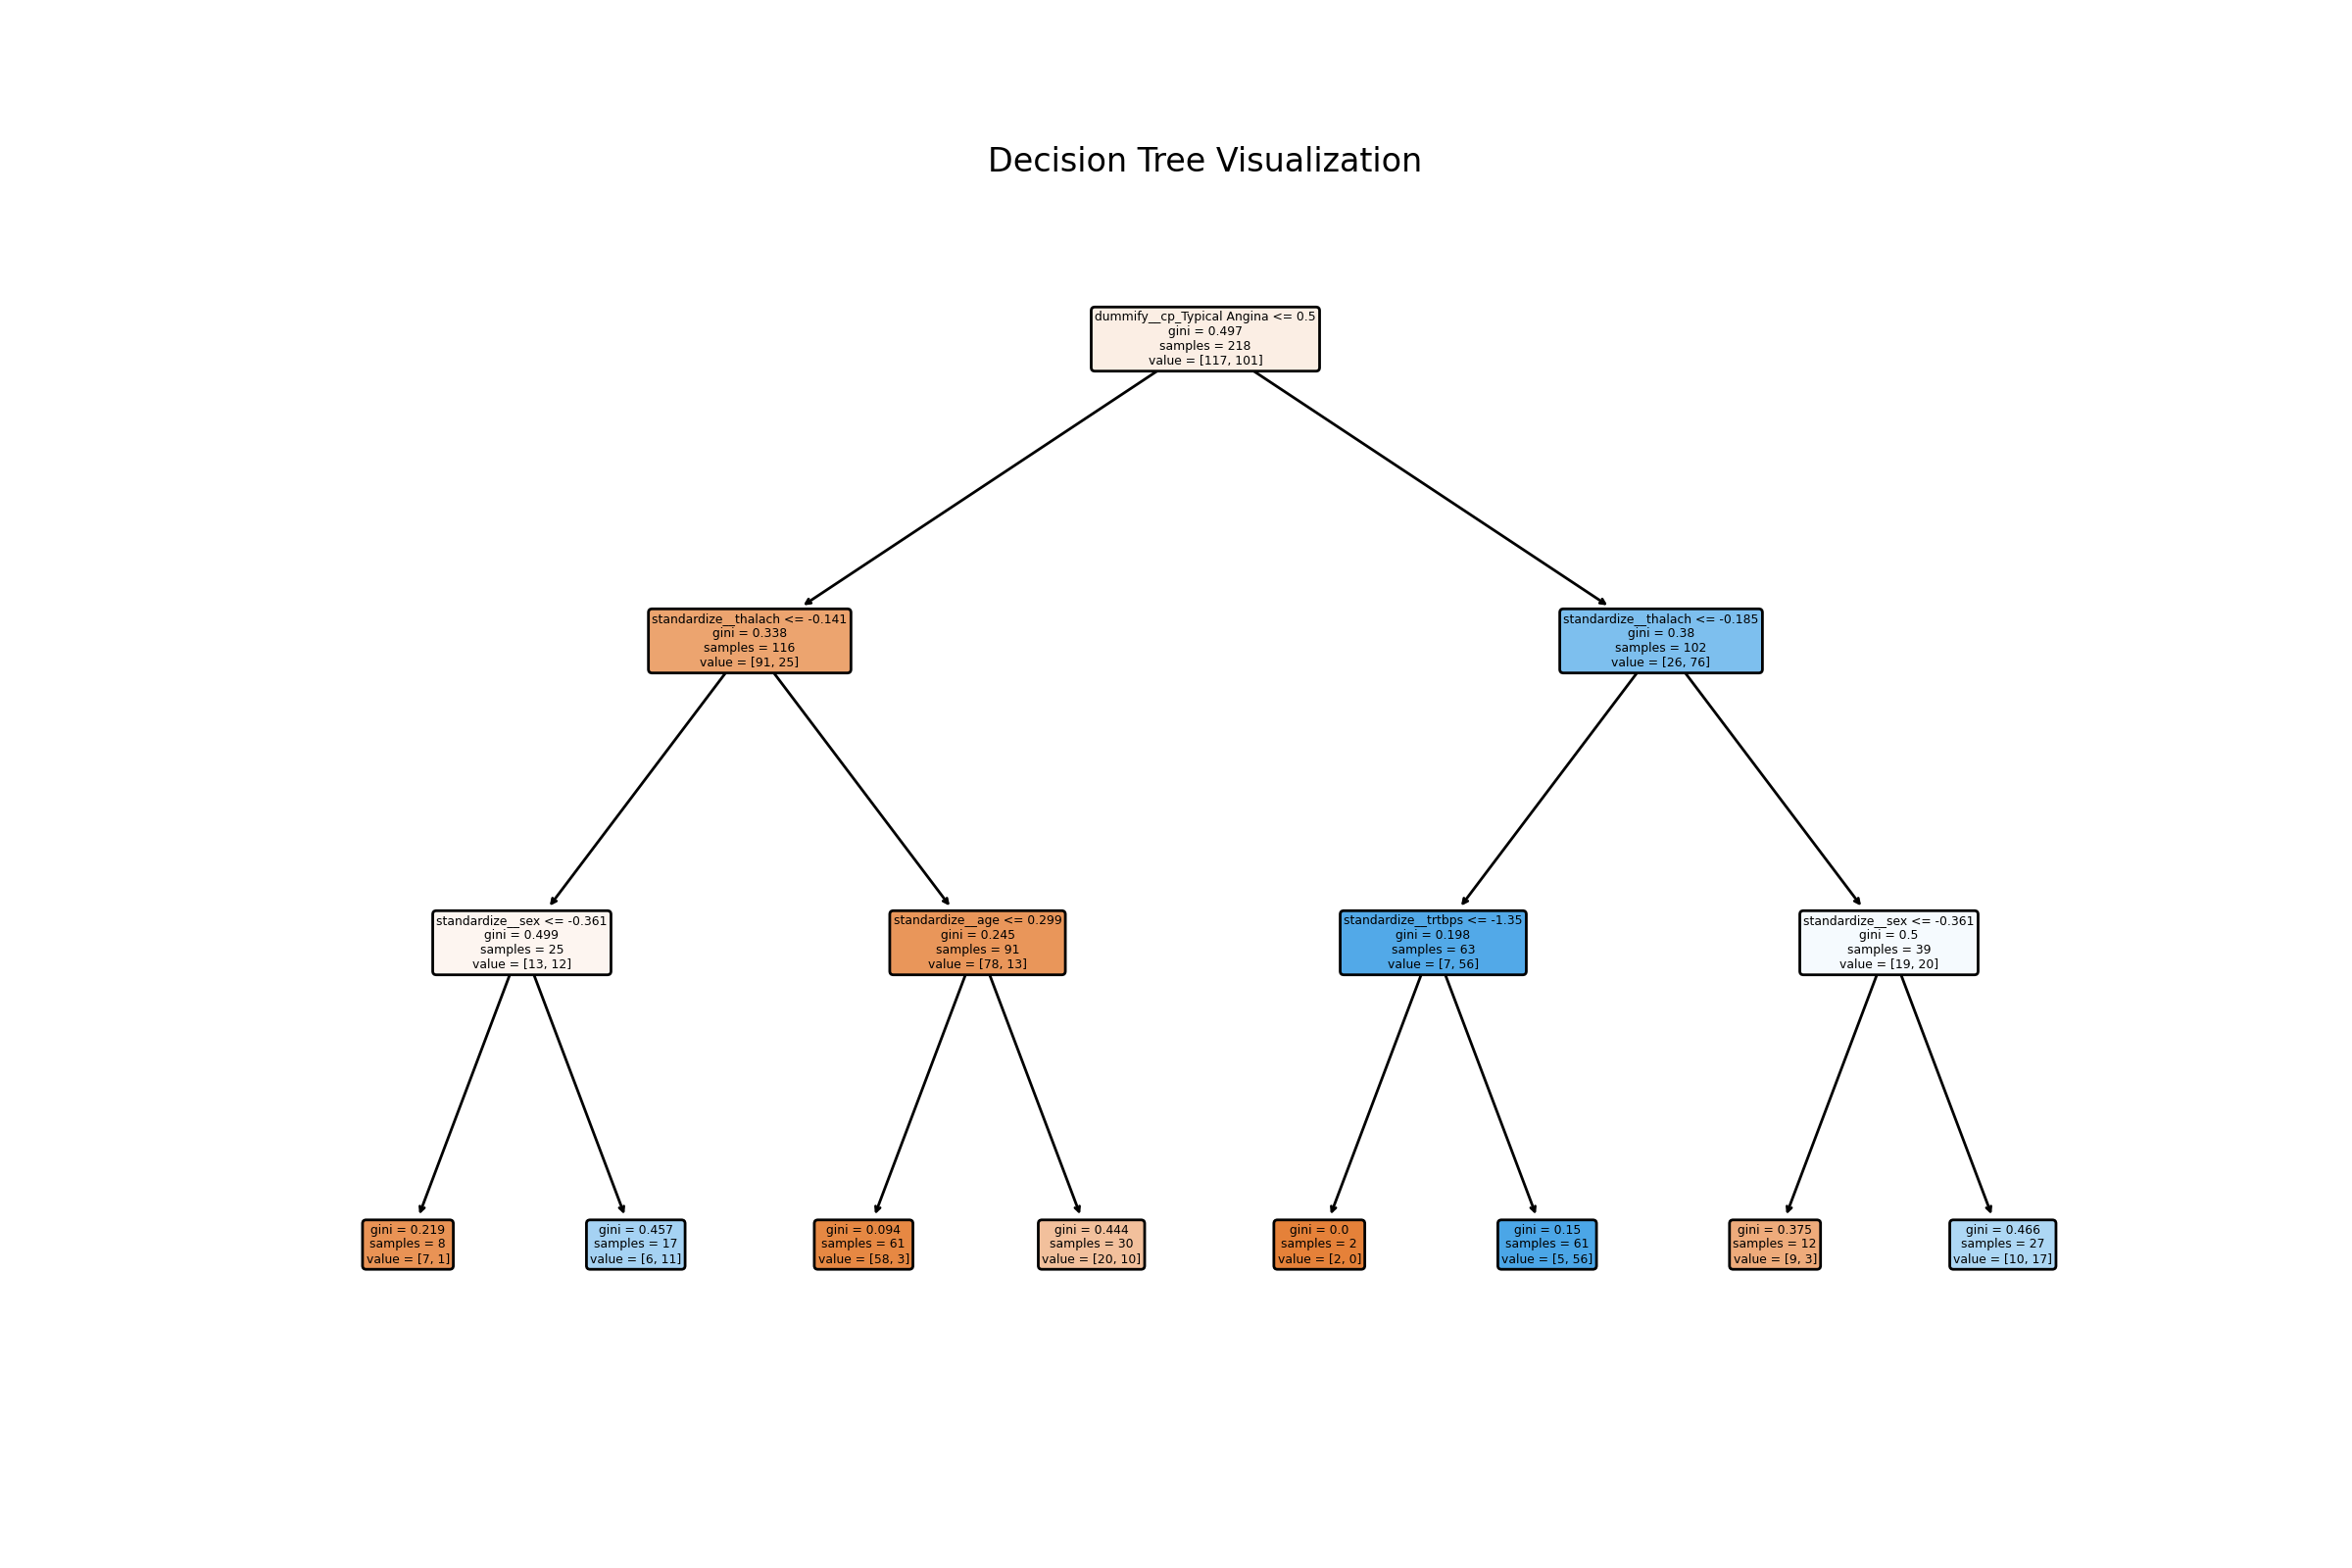

In [ ]:
# Fit the pipeline to your data if you haven't already
my_pipeline_dt.fit(X_train, y_train)

# Extract the Decision Tree model from the pipeline
dt_model = my_pipeline_dt.named_steps['dt']

# Get feature names
feature_names = my_pipeline_dt.named_steps['standardize_dummify'].get_feature_names_out()

# Plot the Decision Tree
plt.figure(figsize=(12, 8))  # Set the size of the plot
plot_tree(dt_model, feature_names=feature_names, filled=True, rounded=True)
plt.title("Decision Tree Visualization")
plt.show()

## Q4: Interpretation

The logistic regression model identified Typical Angina chest pain and gender (Sex) as the most influential positive predictors, meaning they significantly increase the likelihood of heart attack risk. Conversely, Atypical Angina chest pain and Maximum Heart Rate (Thalach) had significant negative effects on the risk. In the decision tree model, Typical Angina, Maximum Heart Rate, Sex, and Age emerged as the most important features for predicting heart attack risk. Both models underscored the importance of Typical Angina as a key predictor. These findings provide valuable insights into the factors contributing to heart attack risk, with potential implications for early detection and prevention.

## Q5: ROC Curve

In [ ]:
# Predict probabilities for each class
y_prob_logreg = my_pipeline_log_regress.predict_proba(X_test)[:, 1]
y_prob_dt = my_pipeline_dt.predict_proba(X_test)[:, 1]
y_prob_knn = my_pipeline_knn.predict_proba(X_test)[:, 1]

In [ ]:
# Calculate ROC curve and AUC for each model
label_binarizer = LabelBinarizer()
y_test_bin = label_binarizer.fit_transform(y_test)

fpr_logreg, tpr_logreg, _ = roc_curve(y_test_bin, y_prob_logreg, pos_label=1)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

fpr_dt, tpr_dt, _ = roc_curve(y_test_bin, y_prob_dt, pos_label=1)
roc_auc_dt = auc(fpr_dt, tpr_dt)

fpr_knn, tpr_knn, _ = roc_curve(y_test_bin, y_prob_knn, pos_label=1)
roc_auc_knn = auc(fpr_knn, tpr_knn)


In [ ]:
# Create DataFrames for ROC curves
roc_df_logreg = pd.DataFrame({'FPR': fpr_logreg, 'TPR': tpr_logreg})
roc_df_logreg['Model'] = 'Logistic Regression'

roc_df_dt = pd.DataFrame({'FPR': fpr_dt, 'TPR': tpr_dt})
roc_df_dt['Model'] = 'Decision Tree'

roc_df_knn = pd.DataFrame({'FPR': fpr_knn, 'TPR': tpr_knn})
roc_df_knn['Model'] = 'k-Nearest Neighbors'

# Combine DataFrames
roc_df = pd.concat([roc_df_logreg, roc_df_dt, roc_df_knn])
roc_df.head(4)

,FPR,TPR,Model
0,0.000000,0.000000,Logistic Regression
1,0.000000,0.038462,Logistic Regression
2,0.000000,0.115385,Logistic Regression
3,0.068966,0.115385,Logistic Regression


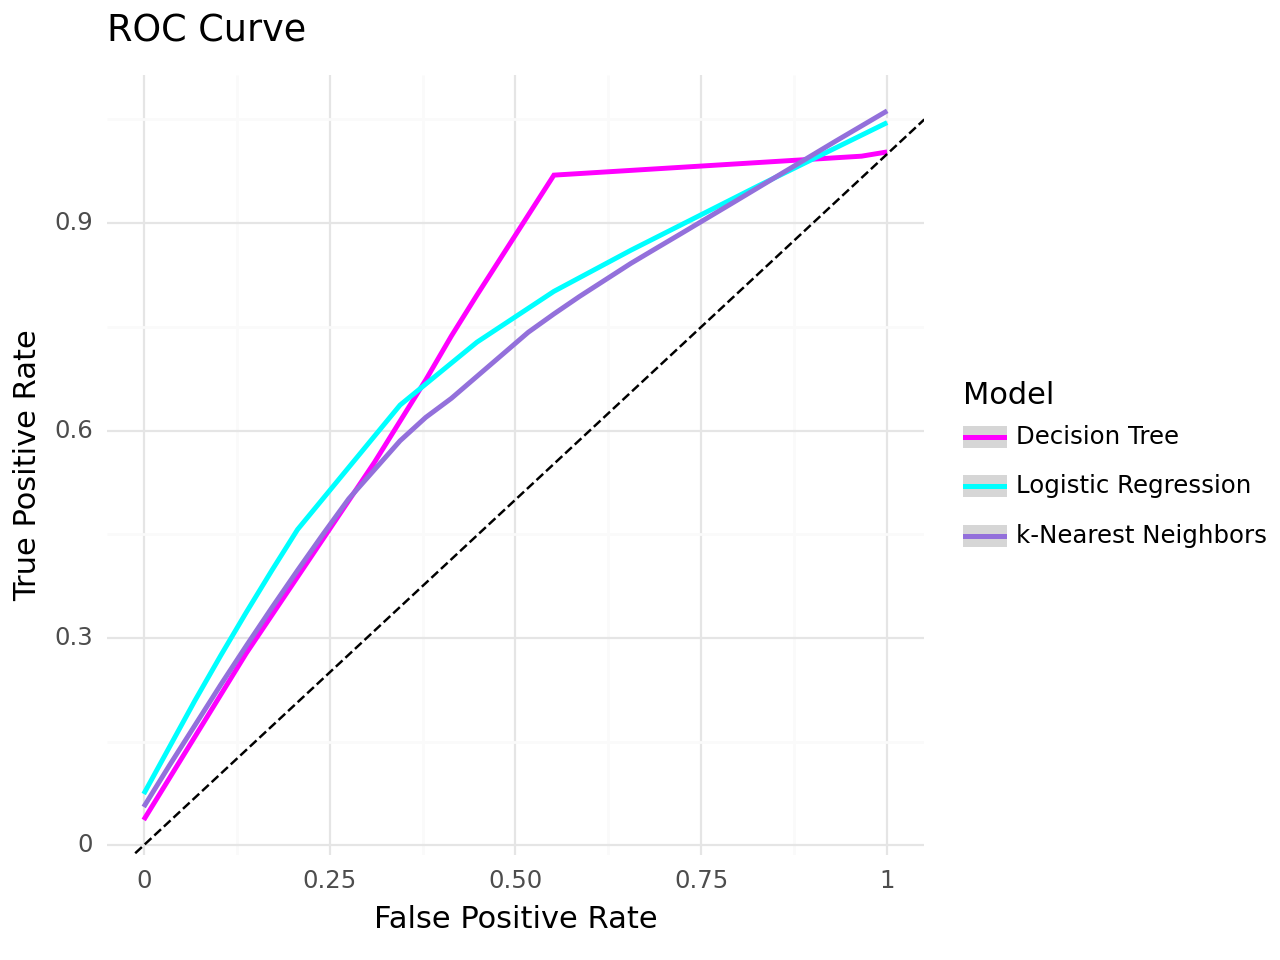

<Figure Size: (640 x 480)>

In [ ]:
roc_plot = (
    ggplot(roc_df, aes(x='FPR', y='TPR', color='Model')) +
    geom_smooth() +
    geom_abline(intercept=0, slope=1, linetype='dashed') +
    labs(title='ROC Curve', x='False Positive Rate', y='True Positive Rate') +
    scale_color_manual(values=['#FF00FF', '#00FFFF', '#9370DB']) +
    theme_minimal()
)

roc_plot

# Part Two: Metrics

### Decision Trees

- Recall (True Positive Rate) for "At risk": 62.1%
- Precision (Positive Predictive Value) for "At risk": 66.7%
- Specificity (True Negative Rate) for "Not at risk": 17/9+17= 65.4%

In [ ]:
# descion trees
recall_scores_df_dt

,precision,recall,f1-score,support
At risk,0.666667,0.620690,0.642857,29.000000
Not at risk,0.607143,0.653846,0.629630,26.000000
accuracy,0.636364,0.636364,0.636364,0.636364
macro avg,0.636905,0.637268,0.636243,55.000000
weighted avg,0.638528,0.636364,0.636604,55.000000


In [ ]:
conf_matrix_df_dt

,At risk,Not at risk
At risk,18,11
Not at risk,9,17


### Log regression

- Recall (True Positive Rate) for "At risk": 58.62%
- Precision (Positive Predictive Value) for "At risk": 68.0%
- Specificity (True Negative Rate) for "Not at risk": 18/8+18= 69.23%

In [ ]:
# log regression
recall_scores


,precision,recall,f1-score,support
At risk,0.680000,0.586207,0.629630,29.000000
Not at risk,0.600000,0.692308,0.642857,26.000000
accuracy,0.636364,0.636364,0.636364,0.636364
macro avg,0.640000,0.639257,0.636243,55.000000
weighted avg,0.642182,0.636364,0.635883,55.000000


In [ ]:
conf_matrix_df1

,At risk,Not at risk
At risk,17,12
Not at risk,8,18


### Knn

- Recall (True Positive Rate) for "At risk": 51.72%
- Precision (Positive Predictive Value) for "At risk": 65.23%
- Specificity (True Negative Rate) for "Not at risk": 18/8+18= 69.23%

In [ ]:
# knn classification
recall_scores1

,precision,recall,f1-score,support
At risk,0.652174,0.517241,0.576923,29.0
Not at risk,0.562500,0.692308,0.620690,26.0
accuracy,0.600000,0.600000,0.600000,0.6
macro avg,0.607337,0.604775,0.598806,55.0
weighted avg,0.609783,0.600000,0.597613,55.0


In [ ]:
conf_matrix_df

,At risk,Not at risk
At risk,15,14
Not at risk,8,18


# Part Three: Discussion

## Q1: The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.

**- Which metric:** Recall is critical in this scenario because it focuses on minimizing false negatives, where a high-risk patient is incorrectly classified as low risk. High recall means the model is more effective in identifying patients who are actually at risk of a heart attack, which is crucial in a legal context where missing such cases could lead to severe lawsuits.

**- Which model:** The Decision Tree model has the highest recall (62.1%) among the three models. Its strength lies in its ability to better identify high-risk patients, reducing the likelihood of falsely classifying a high-risk patient as low risk.

**- What score to expect:** Around 62.1% for Recall.This score indicates that the Decision Tree model will correctly identify approximately 62.1% of the patients who are actually at risk of a heart attack. While not perfect, this is the best performance among the models provided, making it the most suitable choice under these circumstances.




## Q2: The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk

**- Which metric:** We would want to look at specificity for answering this question. This is because we would like to identify people who are known not to be at risk for a heart attack (true negatives) and, at the same time, not categorizing some people as being at risk for a heart attack when they are not at risk (avoiding false positives). This way, bed space will not be taken up by those who are falsely identified as being at risk, and patients can be narrowed down to only those who are in true need of a hospital bed.

**- Which model:** KNN seems to do well so we would use this model

**- What score to expect:** Around 69.23


## Q3: The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.

**- Which metric:** By prioritizing precision, you ensure that when the model predicts a patient is at high risk of a heart attack, this prediction is more likely to be correct. This is crucial for studying root causes because it reduces the number of false alarms - cases where the model incorrectly identifies a risk factor as being significant when it isn't.

**- Which model:** I would look at descion trees is possible since here we can see the order of which features are the most important since they will higher up in our descion tree

**- What score to expect:** around 65.23


## Q4: The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.

- Which metric:  Precision is an appropriate metric in this context because it measures how many of the patients identified by the algorithm as at risk of a heart attack truly are.

- Which model: The Logistic Regression model is chosen based on its precision score. This model has demonstrated a good balance between sensitivity and specificity and is often easier to interpret than more complex models.

- What score to expect: 68%


# Part Four: Validation

In [ ]:
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

In [ ]:
ha_validation= ha.dropna()
ha_validation.head(1)

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,Asymptomatic,145,233,Normal,150,At risk


In [ ]:
X_val= ha.drop(['output'], axis=1)
y_val = ha['output']

## KNN

In [ ]:
# Predict on the validation set
y_pred_val = my_pipeline_knn.predict(X_val)

1. Create the confusion matrix

In [ ]:
# Confusion matrix
conf_matrix_val = confusion_matrix(y_val, y_pred_val)
class_names = y_val.unique().tolist() # Adjust if your target labels are different
conf_matrix_df_val = pd.DataFrame(conf_matrix_val, index=class_names, columns=class_names)
conf_matrix_df_val

,At risk,Not at risk
At risk,114,32
Not at risk,28,99


In [ ]:
# Classification Report
classification_report_val = classification_report(y_val, y_pred_val, output_dict=True)
classification_report_df_val = pd.DataFrame(classification_report_val).transpose()
classification_report_df_val

,precision,recall,f1-score,support
At risk,0.802817,0.780822,0.791667,146.00000
Not at risk,0.755725,0.779528,0.767442,127.00000
accuracy,0.780220,0.780220,0.780220,0.78022
macro avg,0.779271,0.780175,0.779554,273.00000
weighted avg,0.780910,0.780220,0.780397,273.00000


In [ ]:
# ROC AUC using cross-validation on the validation set
cv_scores_log = cross_val_score(my_pipeline_knn, X_val, y_val, cv=5, scoring='roc_auc_ovr')
mean_cv_score_log = cv_scores_log.mean()
mean_cv_score_log

0.8433478337754201

## Q2: Logistic Regression

In [ ]:
# Predict the target variable in the validation dataset
y_pred_val_log = my_pipeline_log_regress.predict(X_val)

1. Create the confusion matrix

In [ ]:
# Confusion matrix
conf_matrix_val = confusion_matrix(y_val, y_pred_val_log)
class_names = y_val.unique().tolist() # Adjust if your target labels are different
conf_matrix_df_val = pd.DataFrame(conf_matrix_val, index=class_names, columns=class_names)
conf_matrix_df_val

,At risk,Not at risk
At risk,119,27
Not at risk,27,100


In [ ]:
# Classification Report
classification_report_validation = classification_report(y_val, y_pred_validation, output_dict=True)
recall_precision_df = pd.DataFrame(classification_report_validation).transpose()
recall_precision_df

,precision,recall,f1-score,support
At risk,0.815068,0.815068,0.815068,146.000000
Not at risk,0.787402,0.787402,0.787402,127.000000
accuracy,0.802198,0.802198,0.802198,0.802198
macro avg,0.801235,0.801235,0.801235,273.000000
weighted avg,0.802198,0.802198,0.802198,273.000000


In [ ]:
# ROC AUC using cross-validation on the validation set
cv_scores_log = cross_val_score(my_pipeline_log_regress, X_val, y_val, cv=5, scoring='roc_auc_ovr')
mean_cv_score_log = cv_scores_log.mean()
mean_cv_score_log

0.8683939876215738

## Q3: Decision Tree

In [ ]:
# Predict the target variable in the validation dataset
y_pred_dt = my_pipeline_dt.predict(X_val)

1. Create the confusion matrix

In [ ]:
onf_matrix_val = confusion_matrix(y_val, y_pred_dt)

# Get unique class names from the target variable of the validation set
class_names = y_val.unique().tolist()  # Adjust if your target labels are different

# Convert the confusion matrix to a DataFrame for better visualization
conf_matrix_df_val = pd.DataFrame(conf_matrix_val, index=class_names, columns=class_names)
conf_matrix_df_val

,At risk,Not at risk
At risk,114,32
Not at risk,26,101


In [ ]:
recall_scores_dt = classification_report(y_val, y_pred_dt, output_dict=True)
recall_scores_df_dt = pd.DataFrame(recall_scores_dt).transpose()
recall_scores_df_dt

,precision,recall,f1-score,support
At risk,0.814286,0.780822,0.797203,146.000000
Not at risk,0.759398,0.795276,0.776923,127.000000
accuracy,0.787546,0.787546,0.787546,0.787546
macro avg,0.786842,0.788049,0.787063,273.000000
weighted avg,0.788752,0.787546,0.787769,273.000000


In [ ]:
cv_scores_dt = cross_val_score(my_pipeline_dt, X_val, y_val, cv=5, scoring='roc_auc_ovr')
mean_cv_score_dt = cv_scores_dt.mean()
mean_cv_score_dt

0.7732371352785147

For all three models, the performance metrics on the validation dataset were either better than or consistent with those on the test dataset. This suggests that the measures of model success were approximately correct or even conservative for the validation data. The improvements in precision and recall for all models on the validation set indicate robustness in the models and their ability to generalize well to new data.

# Part Five: Cohen’s Kappa

### Knn

In [ ]:
y_pred = my_pipeline_knn.predict(X_test)
kappa_knn = cohen_kappa_score(y_test, y_pred)
kappa_knn

0.20707732634338127

### LOG

In [ ]:
y_pred_log = my_pipeline_log_regress.predict(X_test)
kappa_log = cohen_kappa_score(y_test, y_pred_log)
kappa_log

0.2763157894736842

### Decsion Tress

In [ ]:
y_pred_dt = my_pipeline_dt.predict(X_test)
kappa_dt = cohen_kappa_score(y_test, y_pred_dt)
kappa_dt

0.27344782034346105

**Scenarios where we Cohen coeffient is preferred:**

- Imbalanced Data: If the dataset used for predicting heart attack risk is imbalanced, so there are significantly more individuals without heart attacks than those with heart attacks, Cohen's Kappa becomes crucial. This metric accounts for the potential of models to perform well by chance, which is especially relevant when the majority class (no heart attack) dominates the dataset. It ensures that the model's performance is not overestimated due to a high accuracy that might result from simply predicting the majority class.

- Research on Root Causes: If the hospital is conducting research on the root causes of heart attacks and wants to understand which biological measures are associated with heart attack risk, Cohen's Kappa can provide a more accurate evaluation of the model's ability to identify relevant factors. It helps ensure that the associations discovered are not due to random fluctuations in predictions.

The Cohen's Kappa values for the models in the heart attack lab provide a different perspective on their performance compared to precision and recall scores. K-Nearest Neighbors (KNN) achieved a Cohen's Kappa of approximately 0.207, indicating fair agreement(suggests that the model is providing meaningful predictions.) beyond chance, which is slightly lower than the precision (0.65) and recall (0.51) scores reported earlier. Logistic Regression obtained a Cohen's Kappa of around 0.276, signifying fair to moderate agreement beyond chance, slightly higher than the precision (0.68) and recall (0.59) scores. The Decision Tree model yielded a Cohen's Kappa of approximately 0.273, consistent with its precision (0.67) and recall (0.62) scores. Overall, while precision and recall focused on specific aspects of model performance, Cohen's Kappa offered a broader perspective, confirming that all three models exhibit fair to moderate agreement in predicting heart attack risk.